In [1]:
!pip install seaborn scikit-learn

In [1]:
# general imports
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import os
import pandas as pd
import seaborn as sns
import time
import warnings, logging

# pyspark module
from pyspark.rdd import RDD

# src module
from src.data import get_gm, get_kdd
from src.kmeans.base import compute_cost
from src.kmeans.initialization import kMeansParallel_init, kMeansPlusPlus_init, kMeansRandom_init
from src.kmeans.update import lloydKMeans, miniBatchKMeans
from src.utils import sparkSetup

Starting the cluster

In [2]:
# Setup the spark warnings
warnings.filterwarnings("ignore") 
logging.getLogger('py4j').setLevel(logging.ERROR) 
logging.getLogger('pyspark').setLevel(logging.ERROR) 
log4j_conf_path = "./Settings//log4j.properties"

In [3]:
### DOCKER VERSION
from pyspark.sql import SparkSession

spark = (SparkSession.builder 
        .appName("kMeans") 
        .master("spark://spark-master:7077") 
        .config("spark.driver.memory", "4g") 
        .config("spark.executor.memory", "4g") 
        .config("spark.executor.cores", "2") 
        .config("spark.cores.max", "8") 
        .config("spark.network.timeout", "600s")   
        .config("spark.executor.heartbeatInterval", "60s") 
        .getOrCreate()
        )
sc = spark.sparkContext
sc.addPyFile("src.zip")

# Setup the spark warnings
sc.setLogLevel("ERROR")
log4j_conf_path = "./config/log4j.properties"
warnings.filterwarnings("ignore") 
logging.getLogger('py4j').setLevel(logging.ERROR) 
logging.getLogger('pyspark').setLevel(logging.ERROR) 

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/15 12:46:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [34]:
spark

# Load and Test datasets

## Gaussian Mixture

The first dataset we would consider to test the performance of the k-means++ initialization algorithm is a synthetic GaussMixture. To generate it, we sampled $k$ centers from a 15-dimensional spherical Gaussian distribution with mean at the origin and variance $R\in \{1,10,100\}$. We then added points from Gaussian distributions of unit variance around each center. Given the $k$ centers, this is a mixture of $k$ spherical Gaussians with equal weights. The value of the optimal k-clustering
can be well approximated using the centers of these Gaussians.

We will perform some preliminary analysis that can be efficiently conducted on this dataset.

# kMeans|| Init Tests

## Time / Cost tables

The first thing we want to assess with this dataset is the performance in terms of time and cost using different initialization algorithms. In particular, we chose to initialize our k-means algorithm with four different methods:

- **random**;
- **k-means++**;
- **k-means||** with $l\cdot k = 0.5$;
- **k-means||** with $l\cdot k = 2$.

Each initialization method is followed by Lloyd's iterations.

This setup allows us to investigate whether the parallelization introduced by the k-means|| initialization leads to improved clustering performance, using random and k-means++ initializations as baselines.

In [5]:
def compute_initAlgoMetrics(
    initAlgo: str,
    data_ndarray: npt.NDArray, 
    data_rdd: RDD, 
    iterations: int, 
    k: int, 
    l: float, 
    r: int
) -> tuple[float, float, float, float]:
    # Initialization
    startTime = time.time()
    
    if initAlgo == "random": 
        centroids = kMeansRandom_init(data_rdd, k)
    elif initAlgo == "plusplus": 
        centroids = kMeansPlusPlus_init(data_ndarray, k)
    elif initAlgo == "parallel": 
        centroids = kMeansParallel_init(data_rdd, k, l, r)
    else: 
        raise ValueError(f"Wrong initialization algorithm selected: '{initAlgo}'")
         
    initTime = time.time() - startTime
    seedCost = compute_cost(data_rdd, centroids)

    # update centroids
    startTime = time.time()
    finalCentroids = lloydKMeans(data_rdd, centroids, iterations)
    updateTime = time.time() - startTime
    finalCost = compute_cost(data_rdd, finalCentroids)
    
    return initTime, updateTime, seedCost, finalCost

### GM dataset creation

We need to create three different dataset for each value of $R \in \{1, 10, 100\}$.

In [8]:
# --- control parameters ---
k = 50
n = 10_000
dim = 15
R = [1, 10, 100]
r = 5
iterations = 1000
initAlgorithms = ["random", "plusplus", "parallel", "parallel"]
lk_ratios = [0, 0, 0.5, 2]

In [9]:
initAlgoMetrics = []
for variance in R:
    gmData, gmCenters = get_gm(n, k, dim, variance)
    gmData_rdd = sc.parallelize([row for row in gmData], numSlices=16).persist()
    trueCost = compute_cost(gmData_rdd, gmCenters)
    for initAlgo, lk_ratio in zip(initAlgorithms, lk_ratios):
        print(f'R: {variance} | initAlgo: {f"{initAlgo}{lk_ratio}" if initAlgo == "parallel" else initAlgo}')
        initTime, updateTime, seedCost, finalCost = compute_initAlgoMetrics(
            initAlgo = initAlgo,
            data_ndarray = gmData,
            data_rdd = gmData_rdd,
            iterations = iterations,
            k = k,
            l = lk_ratio * k,
            r = r
        )
        initAlgoMetrics.append({
            "R": variance,
            "initAlgo": f"{initAlgo}{lk_ratio}" if initAlgo == "parallel" else initAlgo,
            "initTime": initTime,
            "updateTime": updateTime,
            "seedCost": seedCost,
            "finalCost": finalCost,
            "trueCost": trueCost
        })
    gmData_rdd.unpersist()

initAlgoMetrics = pd.DataFrame(initAlgoMetrics)

R: 1 | initAlgo: random


Exception in thread "serve RDD 20" java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:713)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:757)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:675)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:641)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:617)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:574)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:532)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)


R: 1 | initAlgo: plusplus


R: 1 | initAlgo: parallel0.5


R: 1 | initAlgo: parallel2


R: 10 | initAlgo: random


R: 10 | initAlgo: plusplus


R: 10 | initAlgo: parallel0.5


R: 10 | initAlgo: parallel2


R: 100 | initAlgo: random


R: 100 | initAlgo: plusplus


R: 100 | initAlgo: parallel0.5


R: 100 | initAlgo: parallel2


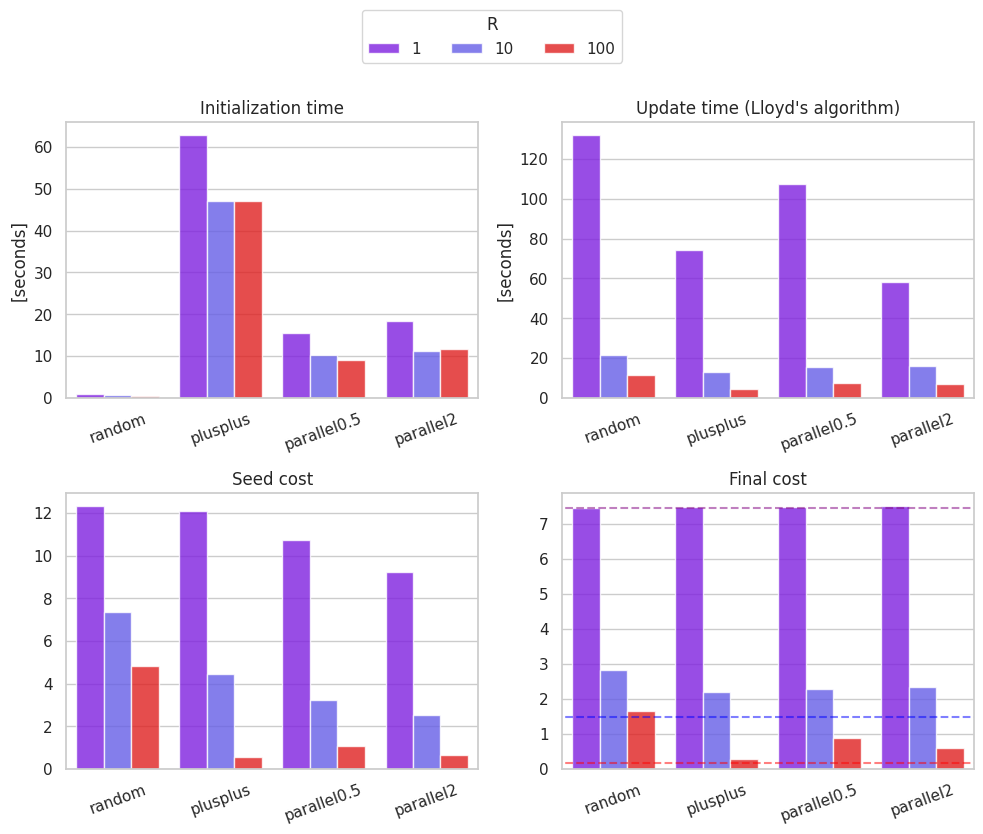

In [ ]:
sns.set_theme(style="whitegrid")
matplotlib.rcParams.update({'font.size': 12})

# Define metrics and titles
metrics = ["initTime", "updateTime", "seedCost", "finalCost"]
units = ["[seconds]", "[seconds]", None, None]
titles = ["Initialization time", "Update time (Lloyd's algorithm)", "Seed cost", "Final cost"]

# Plot
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

for ax, metric, title, unit in zip(axs.flat, metrics, titles, units):
    sns.barplot(
        data = initAlgoMetrics,
        x = "initAlgo",
        y = metric,
        hue = "R",
        palette = "rainbow",
        alpha = 0.8,
        ax = ax
    )
    if title == "Final cost":
        ax.hlines(np.unique(initAlgoMetrics["trueCost"]), xmin = -1, xmax = 4, 
                  colors = ["red", "blue", "purple"], linestyle = "--", alpha = 0.5)
    ax.set_title(title)
    ax.set_xlim(-0.5, 3.5)
    ax.set_xlabel(None)
    ax.set_ylabel(unit)
    ax.tick_params(axis="x", rotation=20)
    ax.get_legend().remove() 


# Legend comune in alto
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc="upper center",
    ncol=len(labels),
    title="R",
    bbox_to_anchor=(0.5, 1.05)  
)

plt.savefig("time_cost_comparison.pdf")
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()

## Cost vs. r plots

In [7]:
def collect_costHistory(
    data_rdd: RDD,
    rounds: list[int],
    k: int,
    lk_ratios: list[float],
    iterations: int,
    verbose: bool = False
) -> dict[int, list]:
    costHistory = {}

    for lk_ratio in lk_ratios:
        costHistory[lk_ratio] = []
        for r in rounds:
            if verbose:
                print(f"lk_ratio: {lk_ratio} | rounds: {r}")
            if r==0:
                finalCentroids = kMeansRandom_init(data_rdd, 1)
            else:
                centroids = kMeansParallel_init(data_rdd, k, lk_ratio * k, r)
                finalCentroids = lloydKMeans(data_rdd, centroids, iterations)
            cost = compute_cost(data_rdd, finalCentroids)
            costHistory[lk_ratio].append(cost)
    return costHistory

In [ ]:
# --- control parameters --- 

# Actual parameters
lk_ratios = [0.5, 1, 2, 5, 10]
rounds = [0, 1, 2, 4, 8, 16]

In [ ]:
R = [1, 10, 100]
baselineCosts = []
costHistory = {}
for variance in R:
    print(f"R: {variance}")
    gmData, gmCenters = get_gm(n, k, dim, variance)
    gmData_rdd = sc.parallelize([row for row in gmData], numSlices=16).persist()
    trueCost = compute_cost(gmData_rdd, gmCenters)

    # baseline (KM++ seeds + Lloyd)
    print("plusplus")
    centroids = kMeansPlusPlus_init(gmData, k)
    finalCentroids = lloydKMeans(gmData_rdd, centroids, iterations)
    baselineCosts.append(compute_cost(gmData_rdd, finalCentroids))
    
    costHistory[variance] = collect_costHistory(gmData_rdd, rounds, k, lk_ratios, iterations, verbose = True)

R: 10


plusplus


lk_ratio: 0.5 | rounds: 1


lk_ratio: 0.5 | rounds: 2


lk_ratio: 0.5 | rounds: 4


lk_ratio: 0.5 | rounds: 8


lk_ratio: 0.5 | rounds: 16


lk_ratio: 1 | rounds: 1


lk_ratio: 1 | rounds: 2


lk_ratio: 1 | rounds: 4


lk_ratio: 1 | rounds: 8


lk_ratio: 1 | rounds: 16


lk_ratio: 2 | rounds: 1


lk_ratio: 2 | rounds: 2


lk_ratio: 2 | rounds: 4


lk_ratio: 2 | rounds: 8


lk_ratio: 2 | rounds: 16


lk_ratio: 5 | rounds: 1


lk_ratio: 5 | rounds: 2


lk_ratio: 5 | rounds: 4


lk_ratio: 5 | rounds: 8


lk_ratio: 5 | rounds: 16


lk_ratio: 10 | rounds: 1


lk_ratio: 10 | rounds: 2


lk_ratio: 10 | rounds: 4


lk_ratio: 10 | rounds: 8


lk_ratio: 10 | rounds: 16


R: 100
plusplus


lk_ratio: 0.5 | rounds: 1


lk_ratio: 0.5 | rounds: 2


lk_ratio: 0.5 | rounds: 4


lk_ratio: 0.5 | rounds: 8


lk_ratio: 0.5 | rounds: 16


lk_ratio: 1 | rounds: 1


lk_ratio: 1 | rounds: 2


lk_ratio: 1 | rounds: 4


lk_ratio: 1 | rounds: 8


lk_ratio: 1 | rounds: 16


lk_ratio: 2 | rounds: 1


lk_ratio: 2 | rounds: 2


lk_ratio: 2 | rounds: 4


lk_ratio: 2 | rounds: 8


lk_ratio: 2 | rounds: 16


lk_ratio: 5 | rounds: 1


lk_ratio: 5 | rounds: 2


lk_ratio: 5 | rounds: 4


lk_ratio: 5 | rounds: 8


lk_ratio: 5 | rounds: 16


lk_ratio: 10 | rounds: 1


lk_ratio: 10 | rounds: 2


lk_ratio: 10 | rounds: 4


lk_ratio: 10 | rounds: 8


lk_ratio: 10 | rounds: 16


In [18]:
def plot_costHistory(
    costHistory: dict[int, dict[int, list]],
    rounds: list[int],
    baselineCosts: list[float]
) -> None:
    matplotlib.rcParams.update({'font.size': 16})
    
    fig, axs = plt.subplots(1, len(costHistory.keys()), figsize=(18, 6))

    for idx, (RR, results) in enumerate(costHistory.items()):
        ax = axs[idx]
        
        ax.hlines(baselineCosts[idx], xmin = rounds[0] - 2, xmax = rounds[-1] + 2, 
                  label = "plusplus", linestyle = "--", alpha = 0.5)
        for lk_ratio in results.keys():
            ax.plot(rounds, results[lk_ratio], label = f"{lk_ratio}",
                    alpha = 0.8)
        
        ax.set_xlim(rounds[0], rounds[-1])
        ax.legend()
    
    plt.show()
    return

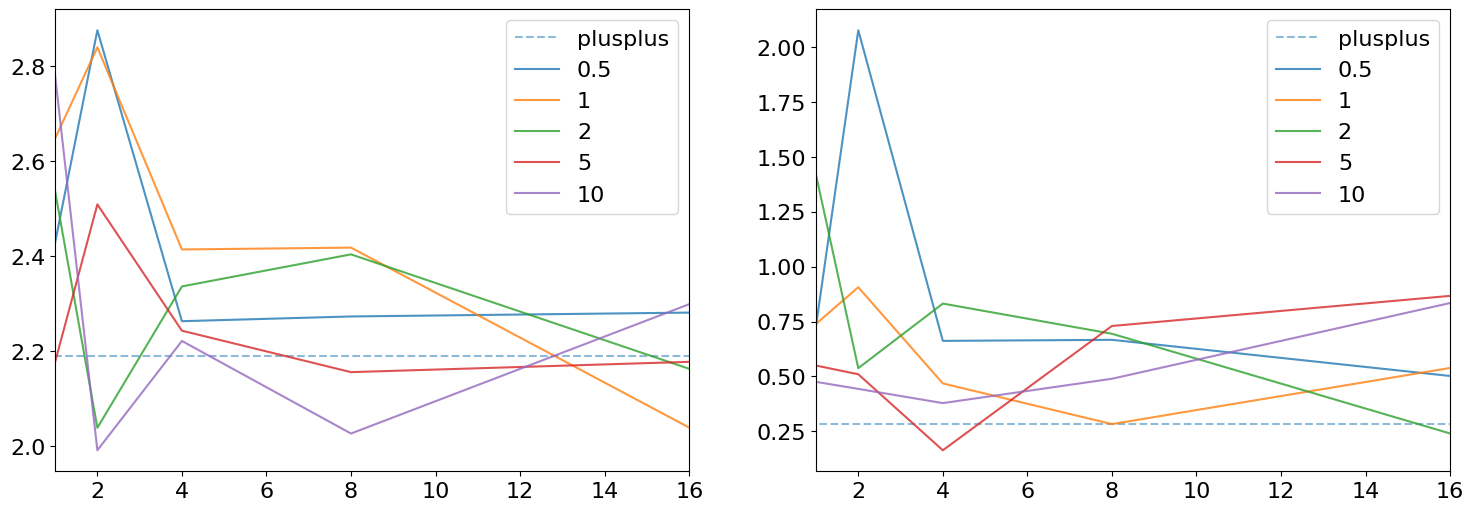

In [19]:
plot_costHistory(costHistory, rounds, baselineCosts)

In [ ]:
def plot_results(
    costHistory: dict[int, list],
    rounds: list[int],
    baselineCost: float
) -> None:
    matplotlib.rcParams.update({'font.size': 16})
    
    fig, axs = plt.subplots(1, len(costHistory.keys()), figsize=(18, 6), sharey=True)

    for idx, (RR, res) in enumerate(costHistory.items()):
        ax = axs[idx]

        curves = res["curves"]
        base = res["base"]
        rounds = res["rounds"]

        # colormap
        lk_values = sorted(curves.keys())
        colors = cm.rainbow(np.linspace(0, 1, len(lk_values)))

        # markers and lines styles
        markers = ["s", "o", "X", "^"]
        lines = ["solid", "dotted", "dashed", "dashdot"]

        for lk, color, marker, line in zip(lk_values, colors, markers, lines):
            phis = curves[lk]
            ax.plot(rounds, phis, marker=marker, markersize=8, markerfacecolor="none", color=color, 
                    linewidth=1.5, linestyle=line, alpha=0.8, label=f"l/k={lk}")

        ax.axhline(base, color="k", lw=1, linestyle="solid", label="KM++ & Lloyd baseline")

        ax.set_title(f"R = {RR}", fontsize=16)
        ax.set_xlabel("# Initialization Rounds")
        if idx == 0:
            ax.set_ylabel("Cost (~$10^{\\alpha}$)")
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: rf"$10^{{{y:.2f}}}$"))
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.legend(frameon=False)

    plt.savefig("lk_plot.pdf")
    plt.tight_layout()
    plt.show()

# Update analysis

## Time vs. n_Partitions

In [10]:
kddData, kddLabels, entries_dict = get_kdd(standardize=True)

In [11]:
k = np.unique(kddLabels).shape[0]
l = 0.5 * k

In [12]:
kddData_rdd = sc.parallelize([row for row in kddData]).persist()
centroids = kMeansParallel_init(kddData_rdd, k, l)
kddData_rdd.unpersist()

ParallelCollectionRDD[0] at readRDDFromFile at PythonRDD.scala:289

In [13]:
time_dict = {}

Lloyd's kMeans serial

In [14]:
start_time = time.time()
final_centroids = lloydKMeans(kddData, centroids, iterations = 100)
delta_time = time.time() - start_time
time_dict[1] = {"lloyd": delta_time}

Parallel

In [ ]:
partitions = [2, 4, 8, 16, 32, 64, 128]
for numSlices in partitions:
    time_dict[numSlices] = {}
    kddData_rdd = sc.parallelize([row for row in kddData], numSlices=numSlices).persist()
    
    start_time = time.time()
    final_centroids = lloydKMeans(kddData_rdd, centroids, iterations = 10, earlyStopping=False)
    delta_time = time.time() - start_time
    time_dict[numSlices]["lloyd"] = delta_time

    start_time = time.time()
    final_centroids = miniBatchKMeans(kddData_rdd, centroids, iterations = 10, earlyStopping=False)
    delta_time = time.time() - start_time
    time_dict[numSlices]["miniBatch"] = delta_time
    
    kddData_rdd.unpersist()

In [ ]:
time_dict

## Spark REST metrics for each n_partitions

The REST API gives access to the values of the Task Metrics collected by Spark executors while executing a task. In the following analysis we give a close look to the following accessible metrics:

| Spark Executor Task Metric name     | Short description                                                                                                                                                   |
|-------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| executorRunTime                     | Time spent running this task. Includes time fetching shuffle data. Value in milliseconds.                               |
| executorCpuTime                     | CPU time spent running this task. Includes time fetching shuffle data. Value expressed in nanoseconds.                                   |
| executorDeserializeTime             | Time spent to deserialize this task. Value expressed in milliseconds.                                                                               |
| executorDeserializeCpuTime         | CPU time taken to deserialize this task. Value expressed in nanoseconds.                                                                                   |
| jvmGCTime                           | Elapsed time the JVM spent in garbage collection while executing this task. Value expressed in milliseconds.                                               |
| ConcurrentGCCount                   | Returns the total number of collections that have occurred.
| ConcurrentGCTime                    | Returns the approximate accumulated collection elapsed time in milliseconds.     |
| resultSerializationTime             | Time spent serializing the task result. Value expressed in milliseconds.                                                                            |
|shuffleReadMetrics.fetchWaitTime     | Time the task spent waiting for remote shuffle blocks. Only includes the time blocking on shuffle input data. For instance, if block B is being fetched while the task is still not finished processing block A, it is not considered to be blocking on block B. The value is expressed in milliseconds.|
|shuffleWriteMetrics.writeTime        | Time spent blocking on writes to disk or buffer cache. The value is expressed in nanoseconds.|

| Executor Level Metric name     |    Short description                                                                                                                         |
|-------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| totalDuration	                      | Elapsed time the JVM spent executing tasks in this executor. The value is expressed in milliseconds.|
|totalGCTime                            |	Elapsed time the JVM spent in garbage collection summed in this executor. The value is expressed in milliseconds.|

In [ ]:
import requests
from urllib.parse import urljoin

In [ ]:
BASE_WEB = (sc.uiWebUrl or "http://localhost:4040").rstrip("/")
BASE_API = BASE_WEB + "/api/v1/"

In [ ]:
def get_app_id():
    """
    get running spark-application's id ...
    """
    apps = requests.get(urljoin(BASE_API, "applications")).json()
    return apps[0]["id"]

def get_executors(app_id):
    """
    get executors' Id, skip the driver ...
    """
    return [exe for exe in requests.get(urljoin(BASE_API, f"applications/{app_id}/executors")).json()
            if exe["id"] != "driver"]

def list_stage_ids(app_id):
    """
    get stage Ids ...
    """
    return [stage["stageId"] for stage in requests.get(urljoin(BASE_API, f"applications/{app_id}/stages")).json()]

def list_attempts(app_id, stage_id):
    """
    get list of all operations that took place in that stage ...
    """
    return requests.get(urljoin(BASE_API, f"applications/{app_id}/stages/{stage_id}")).json()

def task_summary(app_id, stage_id, attempt_id, q="0.5"):
    """
    get task summary of each attempt for each stage ...
    """
    return requests.get(urljoin(BASE_API, f"applications/{app_id}/stages/{stage_id}/{attempt_id}/taskSummary"),
                        params={"quantiles": q}).json()

def _ts(x):
    try:
        return pd.to_datetime(x)
    except Exception:
        return None

In [ ]:
def _stage_totals(app_id, stage_id, att, cores):
    # Units: run/deserialize/result/gc/fetchWait are ms; cpu ns; write ns
    
    run_ms   = float(att.get("executorRunTime", 0.0))
    cpu_ms   = float(att.get("executorCpuTime", 0.0)) / 1e6
    des_ms   = float(att.get("executorDeserializeTime", 0.0))
    ser_ms   = float(att.get("resultSerializationTime", 0.0))
    gc_ms    = float(att.get("jvmGcTime", 0.0))
    # Shuffle totals can sit under nested dicts, but attempts usually expose flat fields:
    fetch_ms = float(att.get("shuffleReadFetchWaitTime", 0.0) or
                     att.get("shuffleReadMetrics.fetchWaitTime", 0.0))
    write_ms = float(att.get("shuffleWriteTime", 0.0) or
                     att.get("shuffleWriteMetrics.writeTime", 0.0)) / 1e6  # ns -> ms

    # Scheduler delay is not always surfaced at attempt totals; derive if available on tasks; else 0
    sched_ms = float(att.get("schedulerDelay", 0.0) or 0.0)

    t0 = _ts(att.get("submissionTime")); t1 = _ts(att.get("completionTime"))
    if t0 is None or t1 is None: return None
    wall_s = max(1e-12, (t1 - t0).total_seconds())

    tasks = int(att.get("numTasks", 0))
    core_util = (run_ms/1000.0) / (max(1, cores) * wall_s)  # totals already sum across tasks

    return {
        "stageId": stage_id,
        "attemptId": att.get("attemptId", 0),
        "wall_s": wall_s,
        "RUN_ms": run_ms,
        "CPU_ms": cpu_ms,
        "OH_ms": des_ms + ser_ms + fetch_ms + write_ms + gc_ms + sched_ms,
        "core_util": core_util,
    }

def collect_run_totals(t0, t1):
    app = get_app_id()
    cores = sum(e["totalCores"] for e in get_executors(app))
    δ = pd.Timedelta(seconds=2.0)
    start, end = t0 - δ, t1 + δ

    recs = []
    for sid in list_stage_ids(app):
        for att in list_attempts(app, sid):
            sub = _ts(att.get("submissionTime")); fin = _ts(att.get("completionTime"))
            if sub is None or fin is None: continue
            if sub >= start and fin <= end:
                r = _stage_totals(app, sid, att, cores)
                if r is not None: recs.append(r)

    if not recs:
        return dict(overhead_share_run=np.nan, cpu_share_run=np.nan,
                    core_util_run=np.nan, stages_df=pd.DataFrame())

    df = pd.DataFrame(recs)
    RUN = df["RUN_ms"].sum()
    OH  = df["OH_ms"].sum()
    CPU = df["CPU_ms"].sum()
    wall = df["wall_s"].sum()
    core_util = (df["RUN_ms"].sum()/1000.0) / (cores * wall)

    return dict(
        overhead_share_run = (OH/RUN) if RUN>0 else np.nan,
        cpu_share_run      = (CPU/RUN) if RUN>0 else np.nan,
        core_util_run      = core_util,
        stages_df          = df.sort_values(["stageId","attemptId"])
    )

def run_with_totals(fn):
    t0 = pd.Timestamp.now(tz="UTC")
    t0m = time.perf_counter()
    fn()
    total_runtime = time.perf_counter() - t0m
    t1 = pd.Timestamp.now(tz="UTC")
    m = collect_run_totals(t0, t1)
    m["total_runtime"] = total_runtime
    return m

In [53]:
# ---------- benchmark loop ----------
results = {}

# serial baseline
t0 = time.time()
_ = lloydKMeans(kddData, centroids, iterations=10)
results[1] = {"lloyd": {"total_runtime": time.time()-t0}}

partitions = [2, 24, 128]
for P in partitions:
    kddData_rdd = sc.parallelize([row for row in kddData], numSlices=P).persist()
    _ = kddData_rdd.count()

    def _ll(): _ = lloydKMeans(kddData_rdd, centroids, iterations=10, earlyStopping=False)
    m_ll = run_with_totals(_ll)

    def _mb(): _ = miniBatchKMeans(kddData_rdd, centroids, iterations=10, earlyStopping=False)
    m_mb = run_with_totals(_mb)

    kddData_rdd.unpersist()

    results[P] = {
        "lloyd":    { "overhead_share_run": m_ll["overhead_share_run"],
                      "cpu_share_run":      m_ll["cpu_share_run"],
                      "core_util_run":      m_ll["core_util_run"],
                      "total_runtime":      m_ll["total_runtime"] },
        "miniBatch":{ "overhead_share_run": m_mb["overhead_share_run"],
                      "cpu_share_run":      m_mb["cpu_share_run"],
                      "core_util_run":      m_mb["core_util_run"],
                      "total_runtime":      m_mb["total_runtime"] },
    }

In [54]:
def to_df(res, algo):
    rows=[]
    for p in sorted(res):
        if algo in res[p]:
            r = res[p][algo]
            rows.append({"n_partitions": p,
                         "overhead_share_run": r.get("overhead_share_run", np.nan),
                         "cpu_share_run":      r.get("cpu_share_run", np.nan),
                         "core_util_run":      r.get("core_util_run", np.nan),
                         "total_runtime_s":    r.get("total_runtime", np.nan)})
    return pd.DataFrame(rows)

df_lloyd = to_df(results, "lloyd")
df_mb    = to_df(results, "miniBatch")

In [55]:
df_lloyd

,n_partitions,overhead_share_run,cpu_share_run,core_util_run,total_runtime_s
0,1,NaN,NaN,NaN,19.188906
1,2,0.208325,NaN,0.268078,41.632359
2,24,0.215106,NaN,0.696682,27.066866
3,128,0.207107,NaN,0.830693,72.857262


In [57]:
df_mb

,n_partitions,overhead_share_run,cpu_share_run,core_util_run,total_runtime_s
0,2,0.453140,NaN,0.213327,13.558419
1,24,0.373942,NaN,0.633115,16.334676
2,128,0.155833,NaN,0.846063,51.603025


25/09/15 16:17:07 ERROR TaskSchedulerImpl: Lost executor 2 on 172.18.0.6: worker lost: Not receiving heartbeat for 60 seconds
25/09/15 16:17:07 ERROR TaskSchedulerImpl: Lost executor 1 on 172.18.0.5: worker lost: Not receiving heartbeat for 60 seconds
25/09/15 16:17:07 ERROR TaskSchedulerImpl: Lost executor 0 on 172.18.0.4: worker lost: Not receiving heartbeat for 60 seconds
25/09/15 17:48:24 ERROR TaskSchedulerImpl: Lost executor 4 on 172.18.0.6: worker lost: Not receiving heartbeat for 60 seconds
25/09/15 17:48:24 ERROR TaskSchedulerImpl: Lost executor 5 on 172.18.0.5: worker lost: Not receiving heartbeat for 60 seconds
25/09/15 17:48:24 ERROR TaskSchedulerImpl: Lost executor 3 on 172.18.0.4: worker lost: Not receiving heartbeat for 60 seconds


### Cost vs iterations


In [31]:
max_epochs = 200

# final results dictionary
results_dict = {
    "lloyd_serial": [],
    "lloyd_parallel": [],
    "minibatch_01": [],
    "minibatch_02": [],
    "minibatch_05": [],
    "minibatch_07": []
}

# partial_results
patience = 3       # number of previous costs to average for stopping
threshold = 1e-3    # convergence threshold

# Parameters
n_runs = 3  # number of independent runs
all_histories_runs = {key: [] for key in results_dict.keys()}

In [ ]:
for key in results_dict.keys():
    print(f"Running {key}")

    for run in range(n_runs):
        print(f"  Run {run+1}/{n_runs}")
        history = []

        current_centroids = centroids.copy()  # initialize centroids

        # compute initial cost
        if key.startswith("minibatch") or key == "lloyd_parallel":
            initial_cost = compute_cost(kddData_rdd, current_centroids)
        else:  # lloyd_serial
            initial_cost = compute_cost(kddData_rdd, current_centroids)
        history.append(initial_cost)

        # compute costs for each epoch
        for epoch in range(max_epochs):
            if key == 'lloyd_serial':
                current_centroids = lloydKMeans(kddData_rdd, centroids=current_centroids, iterations=1)
                cost = compute_cost(kddData_rdd, current_centroids)
            elif key == "lloyd_parallel":
                current_centroids = lloydKMeans(kddData_rdd, centroids=current_centroids, iterations=1)
                cost = compute_cost(kddData_rdd, current_centroids)
            elif key.startswith("minibatch"):
                fraction = {
                    "minibatch_01": 0.1,
                    "minibatch_02": 0.2,
                    "minibatch_05": 0.5,
                    "minibatch_07": 0.7,
                }[key]

                current_centroids = miniBatchKMeans(
                    kddData_rdd, centroids=current_centroids, iterations=1, batch_fraction=fraction
                )
                cost = compute_cost(kddData_rdd, current_centroids)

            history.append(cost)

            # early stopping: compare current cost to average of last `patience` costs
            if len(history) > patience:
                recent_avg = np.mean(history[-patience:])
                if abs(history[-1] - recent_avg) < threshold:
                    break

        # pad history to max_epochs
        if len(history) < max_epochs + 1:  # +1 because of initial cost
            history += [history[-1]] * ((max_epochs + 1) - len(history))

        all_histories_runs[key].append(history)

Running lloyd_serial
  Run 1/3


ERROR:root:KeyboardInterrupt while sending command.              (69 + 6) / 128]
Traceback (most recent call last):
  File "/usr/bin/spark-3.5.5-bin-hadoop3/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/bin/spark-3.5.5-bin-hadoop3/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/socket.py", line 718, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

Exception in thread "serve RDD 1080" java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:713)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:757)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:675)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:641)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:617)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:574)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:532)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)


In [29]:
# Compute mean and std for each algorithm
results_mean_std = {}
for key, histories in all_histories_runs.items():
    arr = np.array(histories)  # shape: (n_runs, max_epochs+1)
    mean_cost = arr.mean(axis=0)
    std_cost = arr.std(axis=0)
    results_mean_std[key] = {"mean": mean_cost, "std": std_cost}

In [30]:
results_dict

{'lloyd_serial': [],
 'lloyd_parallel': [],
 'minibatch_01': [],
 'minibatch_02': [],
 'minibatch_05': [],
 'minibatch_07': []}

In [31]:
results_mean_std

{'lloyd_serial': {'mean': array([33.09530258, 17.42152087, 17.33508682, 17.30840429, 17.29642677,
         17.28257179, 17.27590179, 17.27365812, 17.27185694, 17.23808289,
         17.10388374, 16.98265266, 16.4207255 , 16.20191193, 15.42270152,
         14.33303356, 14.06434536, 14.02070522, 14.0197916 , 14.01987871,
         14.01987871, 14.01987871, 14.01987871, 14.01987871, 14.01987871,
         14.01987871, 14.01987871, 14.01987871, 14.01987871, 14.01987871,
         14.01987871, 14.01987871, 14.01987871, 14.01987871, 14.01987871,
         14.01987871, 14.01987871, 14.01987871, 14.01987871, 14.01987871,
         14.01987871, 14.01987871, 14.01987871, 14.01987871, 14.01987871,
         14.01987871, 14.01987871, 14.01987871, 14.01987871, 14.01987871,
         14.01987871, 14.01987871, 14.01987871, 14.01987871, 14.01987871,
         14.01987871, 14.01987871, 14.01987871, 14.01987871, 14.01987871,
         14.01987871, 14.01987871, 14.01987871, 14.01987871, 14.01987871,
         14.01

In [ ]:
plt.figure(figsize=(12, 6))

# different markers
markers = ['o', 's', '^', 'D', 'x', '*']

# offsets to avoid errorbar overlaps
offsets = [0,1,0,0,1,-1]
for i, (key, stats) in enumerate(results_mean_std.items()):
    mean = stats["mean"]
    std = stats["std"]
    epochs = np.arange(len(mean))

    # line style
    if "lloyd" in key:
        line_style = "--"   
    else:
        line_style = "-"    

    # cycle markers
    marker = markers[i]
    
    plt.errorbar(
        epochs[::10+offsets[i]], mean[::10+offsets[i]], yerr=std[::10+offsets[i]],
        fmt=line_style+marker, capsize=3, label=key
    )
    offset += 1

plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Cost", fontsize=14)
plt.title("K-Means Convergence: Cost vs Epochs", fontsize=16)
plt.grid(alpha=0.6)
plt.legend(title="Algorithm:", loc="best")
plt.show()

Stopping the cluster

In [26]:
sc.stop()
spark.stop()